# Real time Emotion Detection on Video - Overlay

In [3]:
import numpy as np
import pandas as pd
from keras.models import model_from_json, load_model
import face_recognition
import cv2

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
plt.style.use('ggplot')

from tqdm import tqdm


/anaconda3/envs/kerasv6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Part I. Load pretrained Keras models

### Introduction

The emotion recognition model has been trained using the FRET2003 dataset. This dataset consists of 28,709 grayscale images. Each image is categorized each based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

The gender recognition model has been trained using the 'Faces in The Wild' dataset. The gender was infered by the name of the celebrity. The final weakly labelized dataset of approximatelly 250K was used to train the model.

### 1.1 - Gender recognition model

In [10]:
gender_model = load_model('./Trained Model/trained_GenderNet.hdf5')

### 1.2 Emotion recognition model

In [5]:
# load json and create model
json_file = open('./Trained Model/face_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./Trained Model/face_model.h5")
print("Loaded model from disk")

model = loaded_model

Loaded model from disk


## Part II. Functions

In [11]:
def decode(net_output):
    '''EmotionNet output decoder.
    
    '''
    if (np.argmax(net_output) == 0):
        prediction = 'Angry'
    elif (np.argmax(net_output) == 1):
        prediction = 'Disgust'
    elif (np.argmax(net_output) == 2):
        prediction = 'Fear'
    elif (np.argmax(net_output) == 3):
        prediction = 'Happy'
    elif (np.argmax(net_output) == 4):
        prediction = 'Sad'
    elif (np.argmax(net_output) == 5):
        prediction = 'Surprise'
    else:
        prediction = 'Neutral'
        
    return prediction


def decode2(net_output, threshold = 0.3):
    '''EmotionNet output decoder.
    
    '''
    # Check if probability is higher than threshold
    if np.max(net_output) >= threshold:
        probability = str(np.max(net_output))
        if (np.argmax(net_output) == 0):
            prediction = 'Angry'
        elif (np.argmax(net_output) == 1):
            prediction = 'Disgust'
        elif (np.argmax(net_output) == 2):
            prediction = 'Fear'
        elif (np.argmax(net_output) == 3):
            prediction = 'Happy'
        elif (np.argmax(net_output) == 4):
            prediction = 'Sad'
        elif (np.argmax(net_output) == 5):
            prediction = 'Surprise'
        else:
            prediction = 'Neutral'
    else:
        # Do not label the box if you are not sure
        prediction = ''
        probability = ''
    return prediction + ' ' + probability[:5]
       
       
def pre_processing(color_image_rectangle):
    '''Transform input image to EmotionNet input size.
    
    '''
    # Convert image to B&W
    gray_img = cv2.cvtColor(color_image_rectangle,cv2.COLOR_BGR2GRAY)

    # Resize image
    gray_img = cv2.resize(gray_img,(48,48), interpolation = cv2.INTER_CUBIC)

    # Reshape and add mini-batch dimension
    gray_img = np.reshape(gray_img,(48,48,1))
    gray_img = np.expand_dims(gray_img, axis=0)
                      
    return gray_img


def gender_decoder(net_output, threshold=0.7):
    '''GenderNet label decoder -----------------------

    0: male
    1: female
    threshold: Probability minimum threshold to assign a label.
    '''
    if np.max(net_output) > threshold:
        probability = str(np.max(net_output))
        if np.argmax(net_output) == 0:
            prediction = 'Male'
        else:
            prediction = 'Female'
    else:
        prediction = ''
        probability = ''

    return prediction + ' ' + probability[:5]
                    
    
#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

def emotion_decoder(x):
    print(x)
    if x == ' \n ': return 7 #Unsure
    else: net_output = x[0].split()[0]
    
    if (net_output == 'Angry'):
        prediction = 0
    elif (net_output == 'Disgust'):
        prediction = 1
    elif (net_output == 'Fear'):
        prediction = 2
    elif (net_output == 'Happy'):
        prediction = 3
    elif (net_output == 'Sad'):
        prediction = 4
    elif (net_output == 'Surprise'):
        prediction = 5
    else:
        prediction = 6
    return prediction



## Part III. Inference Loop

In [31]:

# Load video
vidcap = cv2.VideoCapture('./Videos/test_m6.mp4')

# Initialize some variables
images = []
frames = []
gender_predictions = []
emotion_predictions = []
face_locations = []
face_encodings = []
face_names = []
process_this_frame = True

success = True

while success:
    # Grab a single frame of video
    #ret, frame = video_capture.read()
    success , frame = vidcap.read()

    # Resize frame of video to 1/4 size for faster face recognition processing
    small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
    
    # Convert the image from BGR color (which OpenCV uses) to RGB color (which face_recognition uses)
    rgb_small_frame = small_frame[:, :, ::-1]  # size (180, 320, 3)
    
    # Only process every other frame of video to save time
    if process_this_frame:
        # Find all the faces and face encodings in the current frame of video
        face_locations = face_recognition.face_locations(rgb_small_frame,
                                                        number_of_times_to_upsample=3)
        #face_locations = face_recognition.face_locations(rgb_small_frame, 
        #                                                 model='CNN',
        #                                                 number_of_times_to_upsample=1)
        
        face_emotions = []
        for face in face_locations:
            
            # Get face coordinates
            top, right, bottom, left = face

            # Crop image 
            face_image = rgb_small_frame[top:bottom, left:right]
                        
            # Pre-process image
            gray_img = pre_processing(face_image)
            
            # Save images
            images.append(gray_img)

            # Predict emotion
            net_output = model.predict(gray_img)
            emotion_predictions.append(net_output)
            # Predict gender
            #net2_output = gender_model.predict(np.expand_dims(cv2.resize(face_image,(64,64)), axis=0))
            net2_output = gender_model.predict(gray_img)
            gender_predictions.append(net2_output)
            
            # Decode output
            prediction = decode2(net_output,0.30)
            gender_prediction = gender_decoder(net2_output,threshold=0.85)
            
            prediction = prediction + '\n' + gender_prediction
            
            # Add emotion to rectangle name
            face_emotions.append(prediction)

    process_this_frame = not process_this_frame

    # Display the results
    for (top, right, bottom, left), emotion in zip(face_locations, face_emotions):
        # Scale back up face locations since the frame we detected in was scaled to 1/4 size
        top *= 4
        right *= 4
        bottom *= 4
        left *= 4
        
        overlay = frame.copy()
    
        # Draw a box around the face
        cv2.rectangle(overlay, (left, top), (right, bottom), (180, 0, 0), 2) #Blue

        font = cv2.FONT_HERSHEY_DUPLEX
        
        y0, dy = 0, 30
        for i, line in enumerate(emotion.split('\n')):
            y = y0 + i*dy
            cv2.putText(overlay, line, (left + 6, bottom - 6 + y), font, 1.0, (255, 255, 255), 1)
        
        opacity = 0.5
        cv2.addWeighted(overlay, opacity, frame, 1 - opacity, 0, frame)
        
        # Save frames to render final videos
        frames.append(frame)
 
    # Display the resulting image
    #cv2.imshow('Video', frame)

    # Hit 'q' on the keyboard to quit!
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

error: /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/resize.cpp:4044: error: (-215) ssize.width > 0 && ssize.height > 0 in function resize


In [32]:
images = np.array(images)
np.save('train_images.npy',images)

In [33]:
frames = np.array(frames)
print('Video analysis - Succeed. {} images analyzed'.format(np.shape(frames)))

Video analysis - Succeed. (4432, 480, 854, 3) images analyzed


In [34]:
np.shape(emotion_predictions)

(2216, 1, 7)

In [35]:
y = [np.argmax(x) for x in emotion_predictions]

In [36]:
y2 = [np.argmax(x) for x in gender_predictions]

In [37]:
my_xticks = 'Angry, Disgust, Fear, Happy, Sad, Surprise, Neutral'.split()

Text(0.5,1,'Histogram of emotions')

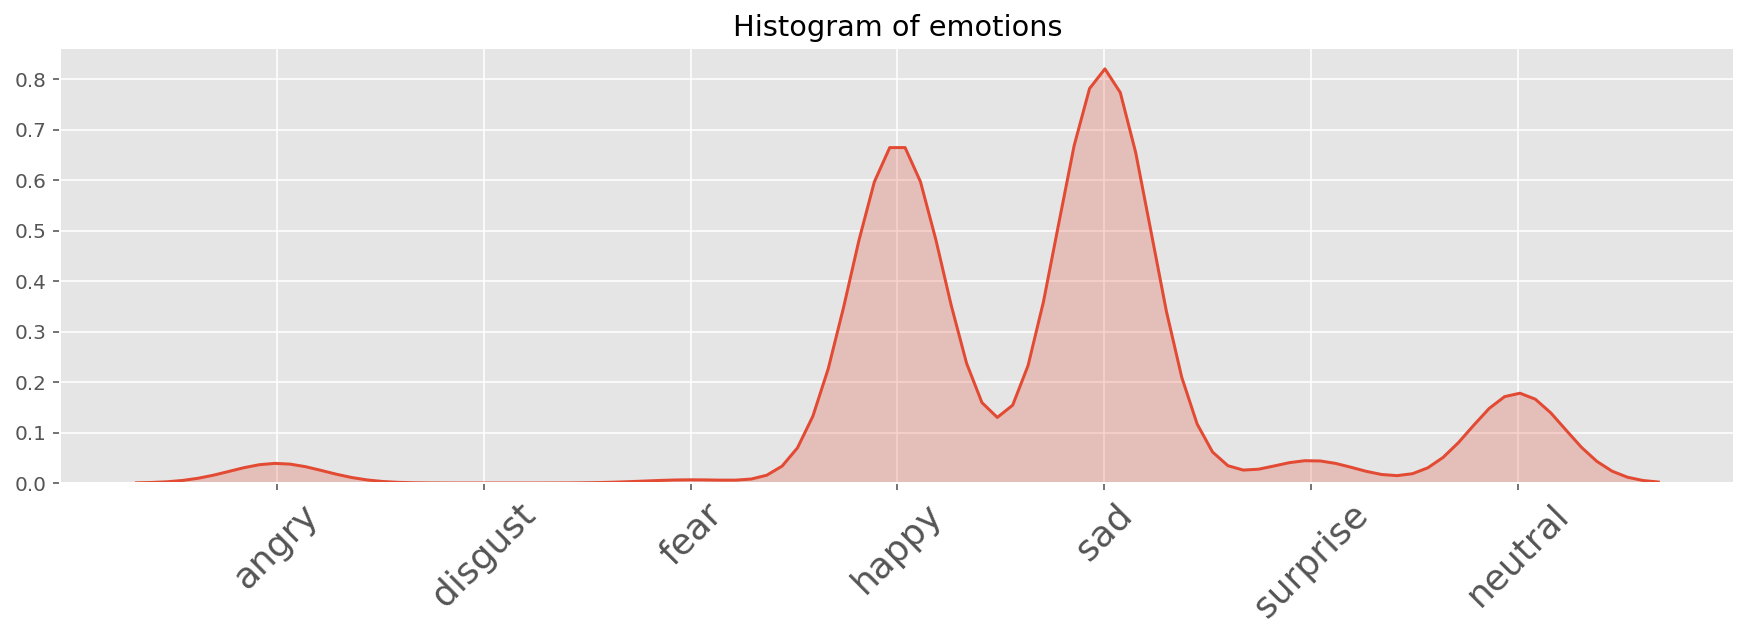

In [38]:
import seaborn as sns
rcParams['figure.figsize'] = 15, 4
sns.kdeplot(y, shade=True)
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral'], 
           rotation=45, fontsize=18)

plt.title('Histogram of emotions')

Text(0.5,1,'Histogram of gender')

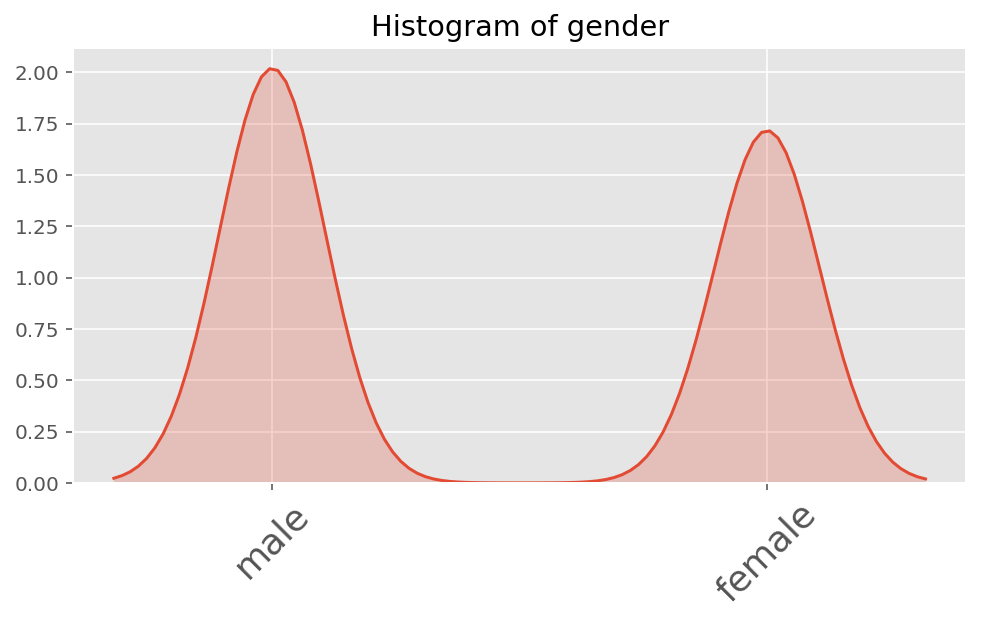

In [39]:
rcParams['figure.figsize'] = 8, 4
sns.kdeplot(y2, shade=True)
plt.xticks([0, 1], ['male', 'female'], 
           rotation=45, fontsize=18)

plt.title('Histogram of gender')

In [40]:
np.shape(frames)

(4432, 480, 854, 3)

### Part IV. Video Rendering

In [36]:
# Create video writer
writer = cv2.VideoWriter("simon_test2.avi", 
                         cv2.VideoWriter_fourcc(*"MJPG"), 
                         50,(854,480))

for frame in tqdm(frames):
    writer.write(frame.astype('uint8'))
    
writer.release()

100%|██████████| 4432/4432 [00:35<00:00, 123.58it/s]
